# Stock Trading Algorithm
Can we predict weekly movement of AAPL stock price?

We want to open either a long or short position at the closing bell of every day with equal investment amounts.  We will close the position exactly five trading days later.  Can we predict whether AAPL will go up or down five days later?

Dataset: We extract daily AAPL OHLC (Open, High, Low, Close) stock price and Volume from NYSE Data on Kaggle (https://www.kaggle.com/dgawlik/nyse)  The data has been adjusted for splits.  We will use derived data for features and our prediction will be based solely on features for a given day.  Features may include daily Volume, Return, Candlestick Pattern, Day of Week, Month, Time of Month, and possible time based technical indicators like Price to Moving Average.

Challenges: This can get challenging and complex since we’re dealing with time based data.  I’m trying to scope the problem to keep it manageable.

In [2]:
# Load Pandas into Python
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
plt.figsize=(15,9)

%matplotlib inline

In [3]:
# Read data
prices = pd.read_csv('prices-split-adjusted.csv')

In [4]:
# Look at one stock
aapl = prices[prices['symbol']=='AAPL']
aapl.columns

Index(['date', 'symbol', 'open', 'close', 'low', 'high', 'volume'], dtype='object')

In [5]:
# Make sure there's no missing data
aapl.describe()

open        close          low         high        volume
count  1762.000000  1762.000000  1762.000000  1762.000000  1.762000e+03
mean     79.427744    79.402683    78.640034    80.140447  9.422578e+07
std      28.339001    28.330794    28.108525    28.561027  6.020519e+07
min      27.481428    27.435715    27.178572    28.000000  1.147590e+07
25%      55.401787    55.450000    54.672501    55.909286  4.917478e+07
50%      78.742146    78.435711    77.631428    79.344284  8.050385e+07
75%     102.979998   103.092503   102.500000   104.424997  1.210816e+08
max     134.460007   133.000000   131.399994   134.539993  4.702495e+08

# Part 3: Clean & Analyze Data

In [6]:
# Generate some features based on data
# Volume, Daily Return, Candlestick Pattern, Day of Week, Month, Time of Month, SMA20-50, SMA0-5
# Plot each one
# Generate Outcome: 5-Day-Return

In [118]:
# Compute some percent changes
# Use look ahead so predictor and outcomes line up 
aapl.head
pd.options.mode.chained_assignment = None  # default='warn'

# Percentage gain of tomorrow's close based on today's close

# tomorrow's close gain pct vs yesterday's close
aapl['today_close_gain_pct'] = 100*(aapl.close - aapl.close.shift(1))/aapl.close.shift(1)

# tomorrow's close gain pct vs yesterday's close
aapl['tomorrow_close_gain_pct'] = 100*(aapl.close.shift(-1) - aapl.close)/aapl.close

# tomorrow's high gain pct vs yesterday's close
aapl['high_close_gain_pct'] = 100*(aapl.high.shift(-1) - aapl.close)/aapl.close

# tomorrow's high gain pct vs yesterday's close
aapl['low_close_loss_pct'] = 100*(aapl.low.shift(-1) - aapl.close)/aapl.close

thresh = 0.9
# 
aapl['is_gain_today'] = aapl['today_close_gain_pct'] > thresh
aapl['is_gain_tomorrow'] = aapl['tomorrow_close_gain_pct'] > thresh
aapl['is_loss_today'] = aapl['today_close_gain_pct'] < -thresh
aapl['is_loss_tomorrow'] = aapl['tomorrow_close_gain_pct'] < -thresh

# tomorrow's high gain pct vs yesterday's close
aapl['low_close_loss_pct'] = 100*(aapl.low.shift(-1) - aapl.close)/aapl.close

In [147]:
from datetime import datetime
aapl.date
# convert to datetime object
dto = pd.to_datetime(aapl.date, format='%Y-%m-%d')
#Return the day of the week as name
aapl['day_of_week'] = dto.dt.weekday_name

aapl_dummies = pd.get_dummies(aapl['day_of_week'])
aapl_new = aapl.join(aapl_dummies)


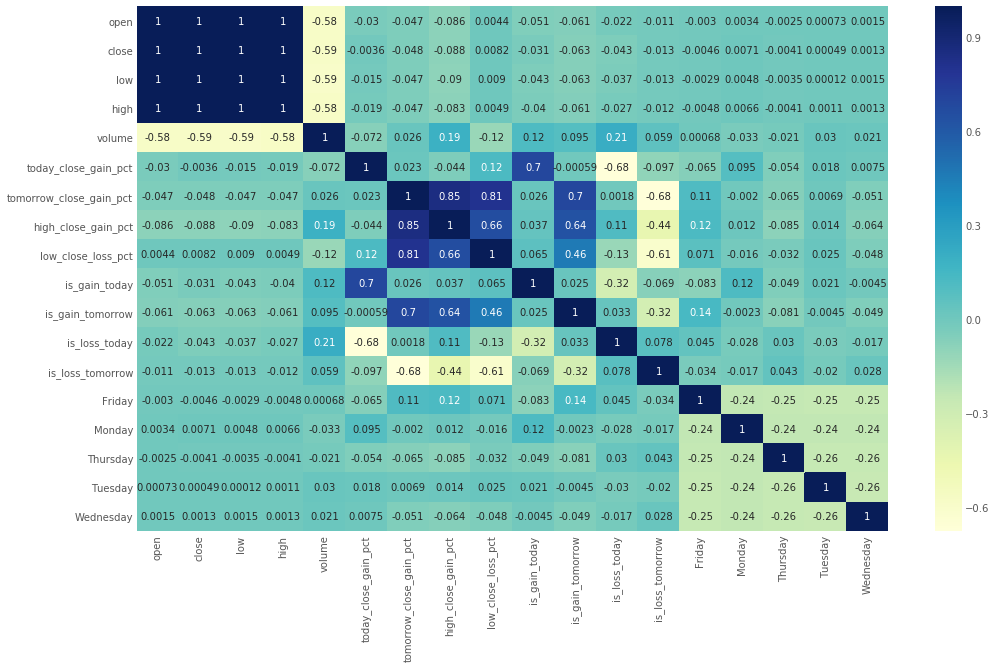

In [145]:
plt.figure(figsize=(15,9))
sns.heatmap(aapl_new.corr(), annot=True, cmap="YlGnBu")

                          count      mean       std        min       25%  \
today_close_gain_pct     1761.0  0.089315  1.651766 -12.355796 -0.755041   
tomorrow_close_gain_pct  1761.0  0.089315  1.651766 -12.355796 -0.755041   
high_close_gain_pct      1761.0  1.030491  1.269389  -9.392810  0.327302   
low_close_loss_pct       1761.0 -0.904476  1.493842 -22.164930 -1.491292   

                              50%       75%        max  
today_close_gain_pct     0.075888  1.032830   8.874137  
tomorrow_close_gain_pct  0.075888  1.032830   8.874137  
high_close_gain_pct      0.866582  1.544394  10.301989  
low_close_loss_pct      -0.717743 -0.092911   8.160202  
                          count      mean       std  min       25%       50%  \
today_close_gain_pct     1761.0  1.196280  1.142109  0.0  0.415928  0.874397   
tomorrow_close_gain_pct  1761.0  1.196280  1.142109  0.0  0.415928  0.874397   
high_close_gain_pct      1761.0  1.192402  1.118584  0.0  0.438598  0.920790   
low_close_loss

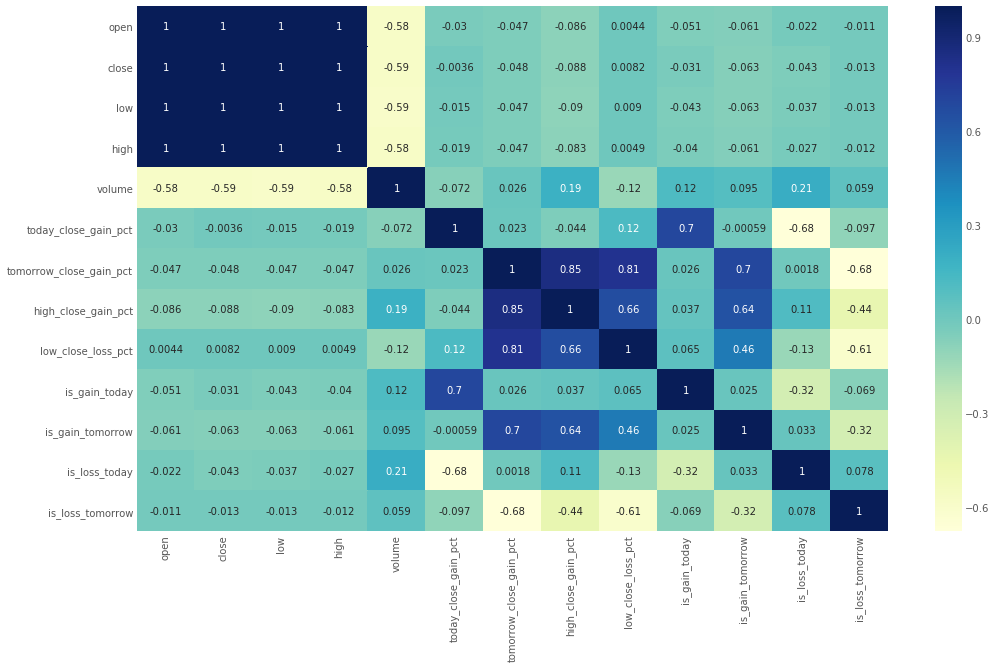

In [142]:
# Look at statistics
fields = ['today_close_gain_pct', 'tomorrow_close_gain_pct', 'high_close_gain_pct', 'low_close_loss_pct']
print (aapl[fields].describe().T)


# look at mean change (either pos or neg)
print (aapl[fields].abs().describe().T)
# on average aaple goes up or down 1.19% in a day
plt.figure(figsize=(15,9))
sns.heatmap(aapl.corr(), annot=True, cmap="YlGnBu")

#sns.pairplot(aapl)

In [79]:
# look at bigger move, i.e high-close for gain and low-close for loss
thresh = 1.0
aapl['is_win_long'] = aapl['next_day_high_pct'] > thresh
aapl['is_win_long_c2c'] = aapl['delta_day_close_pct'] > thresh
aapl[['is_win_long_c2c','is_win_long', 'date', 'close', 'high', 'next_day_high_pct']].head(20)

is_win_long_c2c is_win_long        date      close       high  \
254            False       False  2010-01-04  30.572857  30.642857   
721            False       False  2010-01-05  30.625713  30.798571   
1189           False       False  2010-01-06  30.138571  30.747143   
1657           False       False  2010-01-07  30.082857  30.285715   
2125           False       False  2010-01-08  30.282858  30.285715   
2593           False       False  2010-01-11  30.015715  30.428572   
3061           False        True  2010-01-12  29.674286  29.967142   
3529            True       False  2010-01-13  30.092857  30.132856   
3997           False        True  2010-01-14  29.918571  30.065714   
4465           False        True  2010-01-15  29.418571  30.228571   
4933            True       False  2010-01-19  30.719999  30.741428   
5401           False       False  2010-01-20  30.247143  30.792856   
5869           False       False  2010-01-21  29.724285  30.472857   
6337           False        True  2010-01-22  28.250000  29.642857   
6805            True        True  2010-01-25  29.010000  29.242857   
7273            True        True  2010-01-26  29.420000  30.530001   
7741           False       False  2010-01-27  29.697144  30.082857   
8209           False        True  2010-01-28  28.469999  29.357143   
8677           False        True  2010-01-29  27.437143  28.885714   
9145            True       False  2010-02-01  27.818571  28.000000   

      next_day_high_pct  
254            0.738281  
721            0.396495  
1189           0.488226  
1657           0.674331  
2125           0.481176  
2593          -0.161824  
3061           1.545347  
3529          -0.090199  
3997           1.036144  
4465           4.496673  
4933           0.237165  
5401           0.746232  
5869          -0.273946  
6337           3.514538  
6805           5.239574  
7273           2.253083  
7741          -1.144892  
8209           1.460184  
8677           2.051441  
9145           0.816513

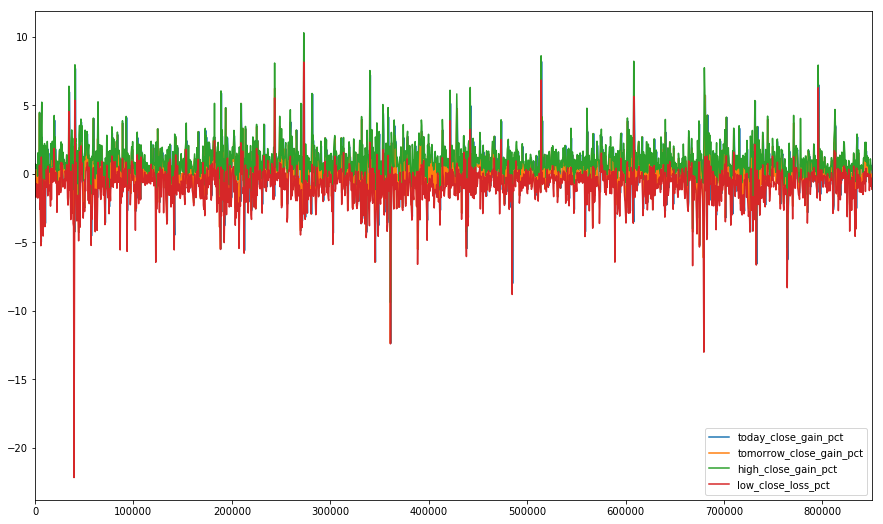

In [99]:
aapl[fields].plot(figsize=(15,9))

In [28]:
aapl.columns
#aapl.head()

Index(['date', 'symbol', 'open', 'close', 'low', 'high', 'volume',
       'delta_day_close', 'delta_day_close_pct', 'max_next_day_high_pct',
       'max_next_day_low_pct', 'max_next_day_gain_pct'],
      dtype='object')

Consider stationary.  Is there trends or seasonality when considering delta_day_close_pct

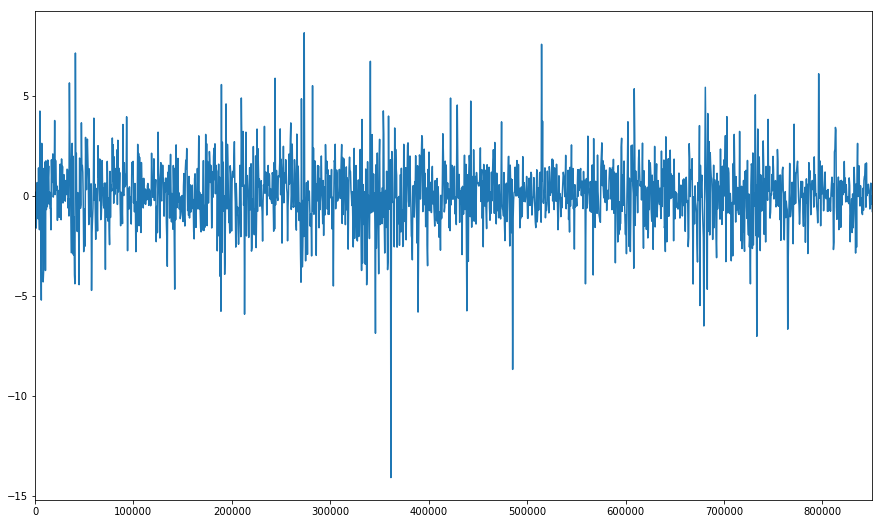

In [6]:
# Use statistics to determine closing_position_thresh
# Set prediction to be categorical data = buy, sell, or defer when threshold of next day is crossed
aapl.delta_day_close_pct.plot(x='date', figsize=(15,9))

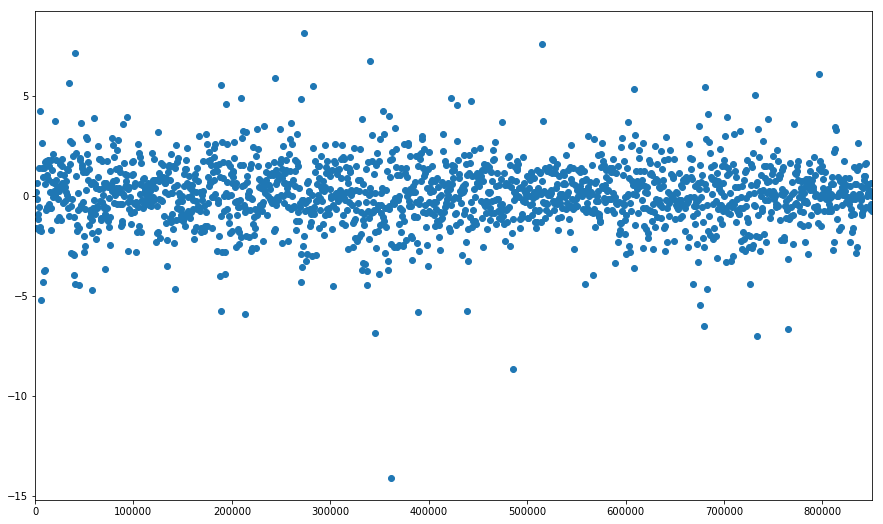

In [7]:
#aapl.plot(kind='scatter', y='delta_day_close_pct')
#plt.plot( y=aapl['delta_day_close_pct'])
aapl.delta_day_close_pct.plot(x='date', style='o', figsize=(15,9))

In [8]:
aapl.delta_day_close_pct.abs().describe()

count    1761.000000
mean        1.195418
std         1.148479
min         0.000000
25%         0.417156
50%         0.875850
75%         1.613379
max        14.097676
Name: delta_day_close_pct, dtype: float64

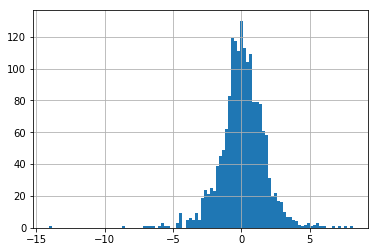

In [9]:
aapl.delta_day_close_pct.hist(bins=100)

In [10]:
aapl.loc[aapl['delta_day_close_pct'].idxmin()]

date                    2013-01-24
symbol                        AAPL
open                       65.7143
close                      64.3571
low                        64.3214
high                       66.5329
volume                 3.65213e+08
delta_day_close           -9.07286
delta_day_close_pct       -14.0977
Name: 361577, dtype: object

Earnings Show iPhones decline to come.
http://money.cnn.com/2013/01/24/investing/apple-stock/index.html


In [11]:
aapl['delta_day_close_pct'].idxmin()

361577

In [12]:
aapl['delta_day_close_pct'].size
aapl.date.count()

1762

In [13]:
import plotly
print(plotly.__version__)           # version 1.9.4 required
plotly.offline.init_notebook_mode() # run at the start of every notebook
plotly.offline.iplot({
"data": [{
    #"x": aapl['close'],
    "y": aapl['delta_day_close_pct']
}],
"layout": {
    "title": "hello world"
}
})

2.0.15


In [15]:
aapl.head()

date symbol       open      close        low       high  \
254   2010-01-04   AAPL  30.490000  30.572857  30.340000  30.642857   
721   2010-01-05   AAPL  30.657143  30.625713  30.464285  30.798571   
1189  2010-01-06   AAPL  30.625713  30.138571  30.107143  30.747143   
1657  2010-01-07   AAPL  30.250000  30.082857  29.864286  30.285715   
2125  2010-01-08   AAPL  30.042856  30.282858  29.865715  30.285715   

           volume  delta_day_close  delta_day_close_pct  
254   123432400.0              NaN                  NaN  
721   150476200.0         0.052856             0.172588  
1189  138040000.0        -0.487143            -1.616343  
1657  119282800.0        -0.055714            -0.185200  
2125  111902700.0         0.200001             0.660442

# Part 4: Build & Test Model

In [ ]:
# Prediction is 5-Day-Return (continuous)
# Another Prediction is 5-Day-Win (Boolean Class)
# Choose LinRegress, KNN, LogisticRegression, DecisionTree/Random Forest/Ensembling
# Do Train Test Split/Cross Validation
# Compute Metric
# Use Regularization to avoid overfitting if needed
# Report Results

**Final Project Deliverables**

Part 1: Test and validate 2-3 initial ideas

Part 2: Select data and outline specific goals

Part 3: Clean and analyze your data

Part 4: Build and document a working model

Part 5: Summarize and present your findings

Optional: Share on Kaggle, Backtest on Quantopian

Part 1: 
Ideas: Simplified trading algo using stock data.
 

Part 2:
    Data: Kaggle Stock Data
        Can we predict next day gain?  We want to build a trading algorithm that will decide to open a position at the close of the trading day with intention of closing the position on the next day. We will close the position if a X% gain is achieved during the next day or at close if that gain is not achieved.

In [ ]:
Part 3: Select AAPL data, 
    create delta parameters
    delta_day_close_pct: close(n) - close(n-1): closing change 
    top_delta_pct: high(n) - close(n-1): highest delta, used for longs
    bot_delta_pct: low(n) - close(n-1): lowest delta, used for shorts

    Remove outliers: assume there is another source to avoid these days
    
    

In [ ]:
Part 4: What is model?
    Day of Week Strategy: Any correlations to days of week? Need to convert date to day of week
    Mean Reversion strategy: Does move the previous day correlate to opposite move the next day?
    
    
        

In [ ]:
Part 5: Present Findings
    Future uses: apply to other stocks and make stock selection

Candlestick Pattern Definitions:
    White: close > open, bullish
    Black: close < open, bearish
    Big Black: close > 0.1*high and open > 1.1*low
    Big Black: close > 0.1*high and open > 1.1*low
    
    https://en.wikipedia.org/wiki/Candlestick_pattern
    http://candlestickgenius.com/top-5-most-consistent-candlestick-patterns/
    http://www.stock-trading-infocentre.com/candle-wicks.html
    http://education.howthemarketworks.com/tools/the-four-most-important-candlestick-patterns-3-videos/

In [ ]:
# Return categorical pattern based on ohlc tuple
def find_candlestick_pattern(ohlc):
    (open, high, low, close) = ohlc
    
    #Default to Plain Black or White
    if (open > close):
        pattern = "White"
    else:
        pattern = "Black"
    # For Big White/Black, wicks are short aka Marubosu
    if (open < 1.1*low && close > 0.1*high):
        if (pattern == 'White')
            pattern = 'Big White'
        else
            pattern = 'Big Black'
    # For Doji, open ~= close and is closer to high (dragonfly) or low (tombstone)
    if ((open-close).abs()< 0.01*(high-low)):
        if (open-low > high-open):
            pattern = 'Dragonfly'
        else:
            pattern = 'Tombstone'
    # For Hammer/Shooting Star, short candles with long wick
    if ((open-close).abs() < 0.02*(high-low)):
        if (open-low > 2*high-open):
            pattern = 'Hammer'
        elif (2*(open-low) < high-open):
            pattern = 'Shooting Star'
    
    return pattern


# Part 5: Present Findings